# Install OpenCV

In [1]:
!pip install opencv-python
!pip install pytesseract
!pip install matplotlib

In [16]:
import cv2
import os
import re
import numpy as np
import pytesseract
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pytesseract import Output
from PIL import Image, ImageOps,  ImageDraw
import colorsys
from datetime import datetime, timedelta
from IPython.display import clear_output, display
from matplotlib.colors import rgb_to_hsv
from scipy.spatial.distance import euclidean
from skimage.measure import label, regionprops
import matplotlib.colors as colors
import matplotlib.dates as mdates

# Define ROI for OCR

In [9]:
# Define the path to the directory containing the images
image_directory = 'Thermal Placement 2'
image_files = os.listdir(image_directory)

# Define your ROI coordinates (x, y, w, h)
roi_hottest = (278, 44, 39, 20)
roi_coldest = (278, 175, 39, 20)

# Apply interpolation & replace invalid value
We decided to use this as hottest temperature got better RMSE (Compare to the accurate one), even though coldest temperature'sRMSE is slightly higher than median function.  

**Int** 	  
MAE_Cold:	0.4705  
MAPE_Cold:	0.0229  
RMSE_Cold:	0.7965  
	
**Avg**	 
MAE_Cold:	0.4639   
MAPE_Cold:	0.0276  
RMSE_Cold:	0.7901  
	
**Int**   
MAE_Hot:	0.1946  
MAPE_Hot:	0.0071  
RMSE_Hot:	0.6068  
	
**Avg**	  
MAE_Hot:	0.8584  
MAPE_Hot:	0.0336  
RMSE_Hot:	1.8496   

In [10]:
def is_interval_close_to_10_minutes(time1, time2):
    """Check if the interval between two times is approximately 10 minutes."""
    interval = abs(time2 - time1)
    return timedelta(minutes=9, seconds=30) < interval < timedelta(minutes=10, seconds=30)

def clean_temperature(ocr_result):
    """Clean the OCR result to extract temperature."""
    cleaned_text = re.sub(r'[^\d.]+', '', ocr_result)
    if not cleaned_text or not re.match(r'^\d{1,2}\.\d$', cleaned_text):
        return 'Invalid'
    temp_value = float(cleaned_text)
    if 13.0 <= temp_value <= 35.0:
        return cleaned_text
    else:
        return 'Invalid'

def interpolate_temperatures(temps):
    """Interpolate 'Invalid' temperatures in a list of temperatures."""
    if not temps or all(temp == 'Invalid' for temp in temps):
        return temps  # Return as is if empty or all invalid
    
    # Convert all valid temperature strings to floats, keep 'Invalid' as is
    for i in range(len(temps)):
        if temps[i] != 'Invalid':
            temps[i] = float(temps[i])

    # Interpolate invalid values
    for i in range(len(temps)):
        if temps[i] == 'Invalid':
            # Find the nearest previous valid temperature
            prev_temp = None
            for j in range(i - 1, -1, -1):
                if temps[j] != 'Invalid':
                    prev_temp = temps[j]
                    break
            
            # Find the nearest next valid temperature
            next_temp = None
            for j in range(i + 1, len(temps)):
                if temps[j] != 'Invalid':
                    next_temp = temps[j]
                    break

            # Calculate the interpolated temperature
            if prev_temp is not None and next_temp is not None:
                temps[i] = (prev_temp + next_temp) / 2
            elif prev_temp is not None:
                temps[i] = prev_temp  # Use the previous temp if no next temp
            elif next_temp is not None:
                temps[i] = next_temp  # Use the next temp if no previous temp

    # Convert temperatures back to string format if necessary
    return [str(temp) if isinstance(temp, float) else temp for temp in temps]

all_results = []

for image_name in image_files:
    if image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp')):
        base_name = os.path.splitext(image_name)[0]
        timestamp_str = base_name.split('_')[1]
        frame_datetime = datetime.strptime(timestamp_str, '%Y%m%d-%H%M%S')

        image_path = os.path.join(image_directory, image_name)
        image = Image.open(image_path)

        cropped_hottest = image.crop((roi_hottest[0], roi_hottest[1], roi_hottest[0] + roi_hottest[2], roi_hottest[1] + roi_hottest[3]))
        gray_hottest = ImageOps.grayscale(cropped_hottest)
        text_hottest = pytesseract.image_to_string(gray_hottest)
        
        cropped_coldest = image.crop((roi_coldest[0], roi_coldest[1], roi_coldest[0] + roi_coldest[2], roi_coldest[1] + roi_coldest[3]))
        gray_coldest = ImageOps.grayscale(cropped_coldest)
        text_coldest = pytesseract.image_to_string(gray_coldest)

        hottest_temp = clean_temperature(text_hottest)
        coldest_temp = clean_temperature(text_coldest)

        all_results.append((frame_datetime, hottest_temp, coldest_temp))

# Sort the results by datetime
sorted_results = sorted(all_results, key=lambda x: x[0])

# Apply filtering for ~10-minute intervals
filtered_results = []
for i in range(1, len(sorted_results)):
    if is_interval_close_to_10_minutes(sorted_results[i-1][0], sorted_results[i][0]):
        filtered_results.append(sorted_results[i-1])
if len(sorted_results) > 1 and is_interval_close_to_10_minutes(sorted_results[-2][0], sorted_results[-1][0]):
    filtered_results.append(sorted_results[-1])

# Separate temperatures and interpolate invalid values for filtered results
hottest_temps = [result[1] for result in filtered_results]
coldest_temps = [result[2] for result in filtered_results]
interpolated_hottest = interpolate_temperatures(hottest_temps)
interpolated_coldest = interpolate_temperatures(coldest_temps)

# Update filtered_results with interpolated temperatures
for i, _ in enumerate(filtered_results):
    filtered_results[i] = (filtered_results[i][0], interpolated_hottest[i], interpolated_coldest[i])

print(f"Total Results After Filtering and Interpolation: {len(filtered_results)}")
for result in filtered_results:
    frame_datetime = result[0].strftime('%Y-%m-%d %H:%M:%S')
    # Ensure temperatures are floats, then format to one decimal place
    hottest = float(result[1]) if result[1] != 'Invalid' else result[1]
    coldest = float(result[2]) if result[2] != 'Invalid' else result[2]
    
    hottest_str = f"{hottest:.1f}" if hottest != 'Invalid' else hottest
    coldest_str = f"{coldest:.1f}" if coldest != 'Invalid' else coldest
    
    print(f"{frame_datetime}: Hottest {hottest_str}, Coldest {coldest_str}")

Total Results After Filtering and Interpolation: 182
2024-03-28 07:17:21: Hottest Invalid, Coldest 20.2
2024-03-28 07:27:22: Hottest Invalid, Coldest 20.2
2024-03-28 07:37:22: Hottest Invalid, Coldest 20.2
2024-03-28 07:47:23: Hottest Invalid, Coldest 20.2
2024-03-28 07:57:23: Hottest Invalid, Coldest 20.2
2024-03-28 08:07:23: Hottest Invalid, Coldest 20.5
2024-03-28 08:17:23: Hottest Invalid, Coldest 20.9
2024-03-28 08:27:24: Hottest Invalid, Coldest 20.7
2024-03-28 08:37:24: Hottest Invalid, Coldest 20.5
2024-03-28 08:47:24: Hottest Invalid, Coldest 20.6
2024-03-28 08:57:24: Hottest Invalid, Coldest 20.8
2024-03-28 09:07:25: Hottest Invalid, Coldest 20.8
2024-03-28 09:17:25: Hottest Invalid, Coldest 20.9
2024-03-28 09:27:25: Hottest Invalid, Coldest 20.6
2024-03-28 09:37:25: Hottest Invalid, Coldest 20.4
2024-03-28 09:47:26: Hottest Invalid, Coldest 20.8
2024-03-28 09:57:26: Hottest Invalid, Coldest 20.7
2024-03-28 10:07:26: Hottest Invalid, Coldest 20.9
2024-03-28 10:17:27: Hottest 

# Heat ratio visualization

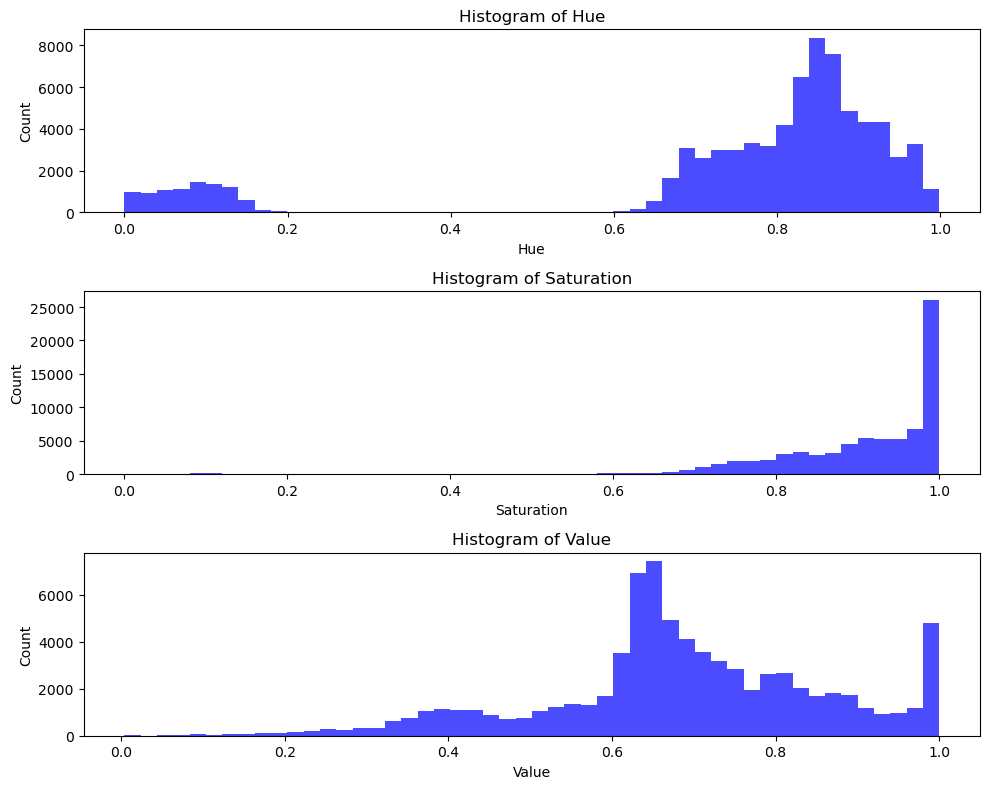

In [17]:
# Load the image
img = Image.open('Thermal Placement 2/photo_20240328-114729.jpg')
pixels = np.array(img)
hsv_pixels = colors.rgb_to_hsv(pixels / 255.0)  # Convert RGB to HSV

# Flatten the image for easier analysis
hsv_pixels_flat = hsv_pixels.reshape(-1, 3)

# Plot histograms for Hue, Saturation, and Value
fig, axs = plt.subplots(3, 1, figsize=(10, 8))
titles = ['Hue', 'Saturation', 'Value']
for i, ax in enumerate(axs):
    ax.hist(hsv_pixels_flat[:, i], bins=50, color='blue', alpha=0.7)
    ax.set_title(f'Histogram of {titles[i]}')
    ax.set_xlabel(titles[i])
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

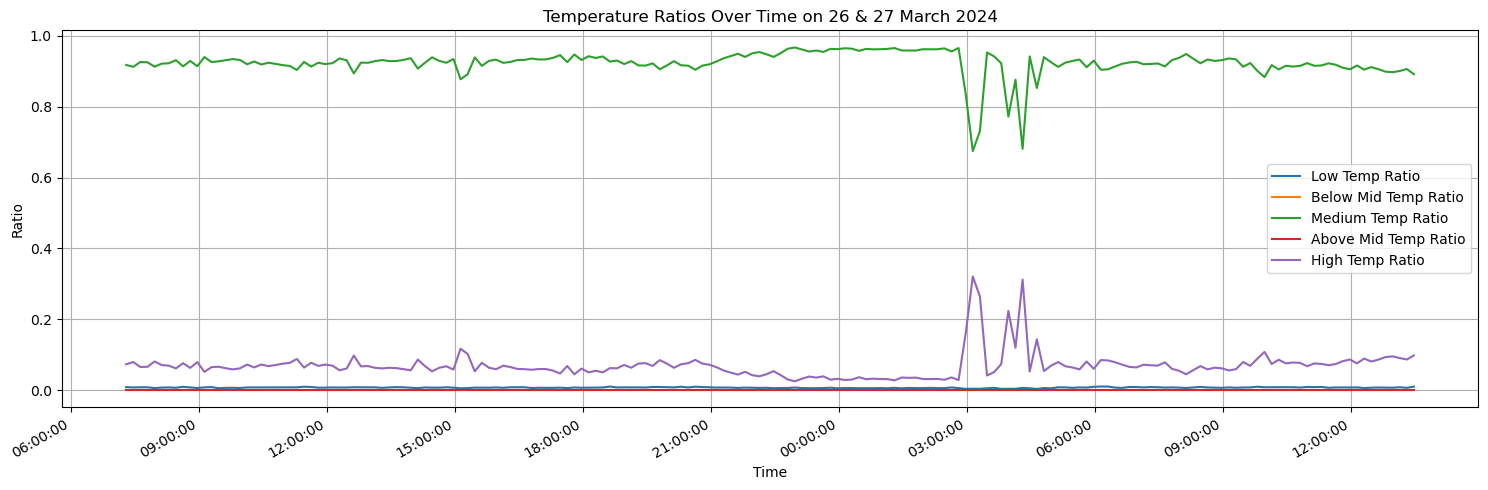

In [18]:
# Your image directory and sorting
image_directory = 'Thermal Placement 2'
image_files = sorted(os.listdir(image_directory))

# Storage for ratios
ratios = {
    'timestamp': [],
    'low_ratio': [],
    'below_mid_ratio': [],
    'medium_ratio': [],
    'above_mid_ratio': [],
    'high_ratio': []
}


# Process each image
for image_file in image_files:
    # Extract timestamp from filename (assuming format 'photo_YYYYMMDD-HHMMSS.jpg')
    timestamp = datetime.strptime(image_file, 'photo_%Y%m%d-%H%M%S.jpg')
    
    # Load the image
    img = Image.open(os.path.join(image_directory, image_file))
    pixels = np.array(img)

    # Convert RGB to HSV (your categorize_pixel function will be used here)
    hsv_pixels = rgb_to_hsv(pixels / 255.0)

    # Categorize each pixel (make sure your categorize_pixel function is correctly defined)
    categories = np.array([[categorize_pixel(pixel) for pixel in row] for row in hsv_pixels])

    # Flatten the categories array to count occurrences
    flat_categories = categories.flatten()
    
    # Count the occurrences of each category
    low_count = np.sum(flat_categories == 'low')
    below_mid_count = np.sum(flat_categories == 'below_mid')
    above_mid_count = np.sum(flat_categories == 'above_mid')
    medium_count = np.sum(flat_categories == 'medium')
    high_count = np.sum(flat_categories == 'high')
    total_pixels = flat_categories.size
    
    # Append the ratios and timestamp to the storage dictionary
    ratios['timestamp'].append(timestamp)
    ratios['low_ratio'].append(low_count / total_pixels)
    ratios['below_mid_ratio'].append(below_mid_count / total_pixels)
    ratios['above_mid_ratio'].append(above_mid_count / total_pixels)
    ratios['medium_ratio'].append(medium_count / total_pixels)
    ratios['high_ratio'].append(high_count / total_pixels)

# Create a DataFrame from the ratios dictionary
df = pd.DataFrame(ratios)

# Plotting the ratios over time
plt.figure(figsize=(15, 5))
plt.plot(df['timestamp'], df['low_ratio'], label='Low Temp Ratio')
plt.plot(df['timestamp'], df['below_mid_ratio'], label='Below Mid Temp Ratio')
plt.plot(df['timestamp'], df['medium_ratio'], label='Medium Temp Ratio')
plt.plot(df['timestamp'], df['above_mid_ratio'], label='Above Mid Temp Ratio')
plt.plot(df['timestamp'], df['high_ratio'], label='High Temp Ratio')

# Formatting the plot
plt.title('Temperature Ratios Over Time on 26 & 27 March 2024')
plt.xlabel('Time')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True)

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

# Show the plot
plt.tight_layout()
plt.show()